# **Color Magnification**

In this notebook we will learn how to reveal hidden color vairations in a video! This is called color magnfiication. 

In [1]:
import os
from glob import glob
import numpy as np 
import cv2
import matplotlib.pyplot as plt 

%matplotlib inline

Get video path

Add your datapath here
You get download videos used for this tutorial [here](http://people.csail.mit.edu/mrub/evm/)

In [2]:
DATA_PATH = r"C:\Users\itber\Documents\learning\self_tutorials\phase_based\videos" # add your data path here

In [3]:
VIDEO_NAME = "face.mp4"

VIDEO_PATH = os.path.join(DATA_PATH, VIDEO_NAME)

os.path.exists(VIDEO_PATH)

True

## Set Hyperparameters

In [4]:
# video magnification factor
ALPHA = 50.0

# Gaussian Pyramid Level of which to apply magnfication?
LEVEL = 4

# Temporal Filter parameters
f_lo = 50/60
f_hi = 60/60

# OPTIONAL: override fs
MANUAL_FS = None
VIDEO_FS = None

# video frame scale factor
SCALE_FACTOR = 1.0

### Colorspace Functions

In [5]:
## Color spaces
def rgb2yiq(rgb):
    """ Converts an RGB image to YIQ using FCC NTSC format.
        This is a numpy version of the colorsys implementation
        https://github.com/python/cpython/blob/main/Lib/colorsys.py
        Inputs:
            rgb - (N,M,3) rgb image
        Outputs
            yiq - (N,M,3) YIQ image
        """
    # compute Luma Channel
    y = rgb @ np.array([[0.30], [0.59], [0.11]])

    # subtract y channel from red and blue channels
    rby = rgb[:, :, (0,2)] - y

    i = np.sum(rby * np.array([[[0.74, -0.27]]]), axis=-1)
    q = np.sum(rby * np.array([[[0.48, 0.41]]]), axis=-1)

    yiq = np.dstack((y.squeeze(), i, q))
    
    return yiq


def bgr2yiq(bgr):
    """ Coverts a BGR image to float32 YIQ """
    # get normalized YIQ frame
    rgb = np.float32(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    yiq = rgb2yiq(rgb)

    return yiq


def yiq2rgb(yiq):
    """ Converts a YIQ image to RGB.
        Inputs:
            yiq - (N,M,3) YIQ image
        Outputs:
            rgb - (N,M,3) rgb image
        """
    r = yiq @ np.array([1.0, 0.9468822170900693, 0.6235565819861433])
    g = yiq @ np.array([1.0, -0.27478764629897834, -0.6356910791873801])
    b = yiq @ np.array([1.0, -1.1085450346420322, 1.7090069284064666])
    rgb = np.clip(np.dstack((r, g, b)), 0, 1)
    return rgb


inv_colorspace = lambda x: cv2.normalize(
    yiq2rgb(x), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC3)

#### Get Video Frames

In [6]:
frames = [] # frames for processing
cap = cv2.VideoCapture(VIDEO_PATH)

# video sampling rate
fs = cap.get(cv2.CAP_PROP_FPS)

idx = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        break

    if idx == 0:
        og_h, og_w, _ = frame.shape
        w = int(og_w*SCALE_FACTOR)
        h = int(og_h*SCALE_FACTOR)

    # convert normalized uint8 BGR to the desired color space
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = bgr2yiq(np.float32(frame/255))

    # append resized frame
    frames.append(cv2.resize(frame, (w, h)))

    idx += 1
    
    
cap.release()
cv2.destroyAllWindows()
del cap

In [7]:
NUM_FRAMES = len(frames)
NUM_FRAMES

301

In [8]:
frames[0].min(axis=0).min(axis=0), frames[0].max(axis=0).max(axis=0)

(array([ 0.03937255, -0.12654472, -0.05871295]),
 array([0.99305882, 0.48281059, 0.19930981]))

Override sampling frequency

In [9]:
print(f"Detected Video Sampling rate: {fs}")

if MANUAL_FS:
    print(f"Overriding to: {MANUAL_FS}")
    fs = MANUAL_FS
    VIDEO_FS = fs
else:
    VIDEO_FS = fs

Detected Video Sampling rate: 30.0


## Get Temporal Filter

In [10]:
import scipy.signal as signal


bandpass = signal.firwin(numtaps=NUM_FRAMES,
                         cutoff=(f_lo, f_hi),
                         fs=fs,
                         pass_zero=False)

In [11]:
transfer_function = np.fft.fft(np.fft.ifftshift(bandpass))

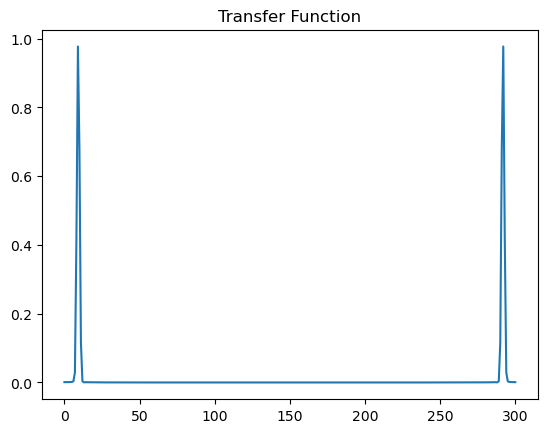

In [12]:
plt.plot(np.abs(transfer_function))
plt.title("Transfer Function");

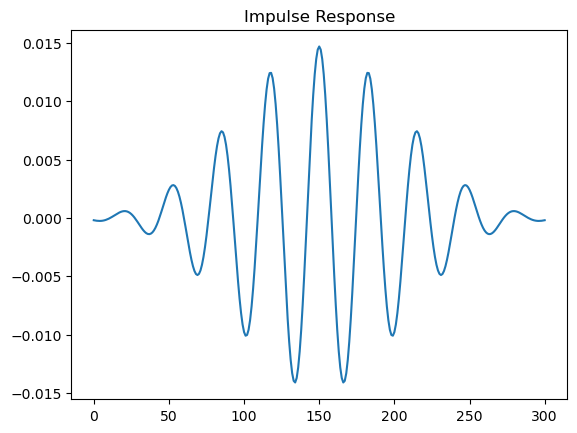

In [13]:
plt.plot(bandpass)
plt.title("Impulse Response");

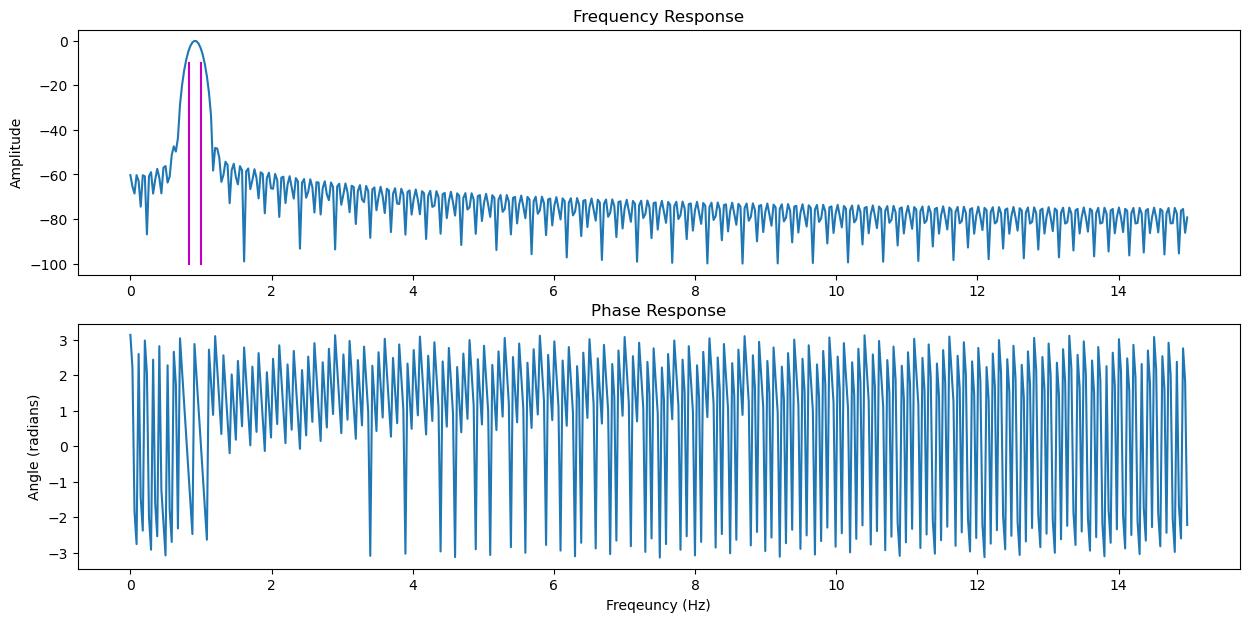

In [14]:
norm_freqs, response = signal.freqz(bandpass)
freqs = norm_freqs / np.pi * fs/ 2 

_, ax = plt.subplots(2, 1, figsize=(15, 7))
ax[0].plot(freqs, 20*np.log10(np.abs(response)));
ax[0].plot([f_lo, f_lo], [-100, -10], color='m')
ax[0].plot([f_hi, f_hi], [-100, -10], color='m')
ax[0].set_title("Frequency Response");
ax[0].set_ylabel("Amplitude");

ax[1].plot(freqs, np.angle(response));
ax[1].set_title("Phase Response");
ax[1].set_xlabel("Freqeuncy (Hz)");
ax[1].set_ylabel("Angle (radians)");

### Gaussian Pyramid

In [15]:
def gaussian_pyramid(image, level):
    """ Obtains single band of a Gaussian Pyramid Decomposition
        Inputs: 
            image - single channel input image
            num_levels - number of pyramid levels
        Outputs:
            pyramid - Pyramid decomposition tensor
        """ 
    rows, cols, colors = image.shape
    scale = 4*level
    pyramid = np.zeros((colors, rows//scale, cols//scale))

    for i in range(0, level):
        # image = cv2.pyrDown(image)

        image = cv2.pyrDown(image, dstsize=(cols//2, rows//2))
        rows, cols, _ = image.shape

        if i == (level - 1):
            for c in range(colors):
                pyramid[c, :, :] = image[:, :, c]

    return pyramid

In [16]:
rows, cols, colors = frames[0].shape
scale = 4*LEVEL
pyramid_stack = np.zeros((NUM_FRAMES, colors, rows//scale, cols//scale))

In [17]:
for i, frame in enumerate(frames):
    pyramid = gaussian_pyramid(frame, LEVEL)
    pyramid_stack[i, :, :, :] = pyramid

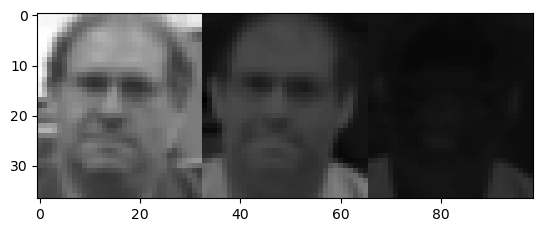

In [18]:
plt.imshow(pyramid_stack[0, :, :, :].transpose(1, 0, 2).reshape((pyramid.shape[1], -1)), cmap='gray');

#### Apply Temporal Filtering

In [19]:
pyr_stack_fft = np.fft.fft(pyramid_stack, axis=0).astype(np.complex64)
_filtered_pyramid = pyr_stack_fft * transfer_function[:, None, None, None].astype(np.complex64)
filtered_pyramid = np.fft.ifft(_filtered_pyramid, axis=0).real

In [20]:
pyr_stack_fft.shape

(301, 3, 37, 33)

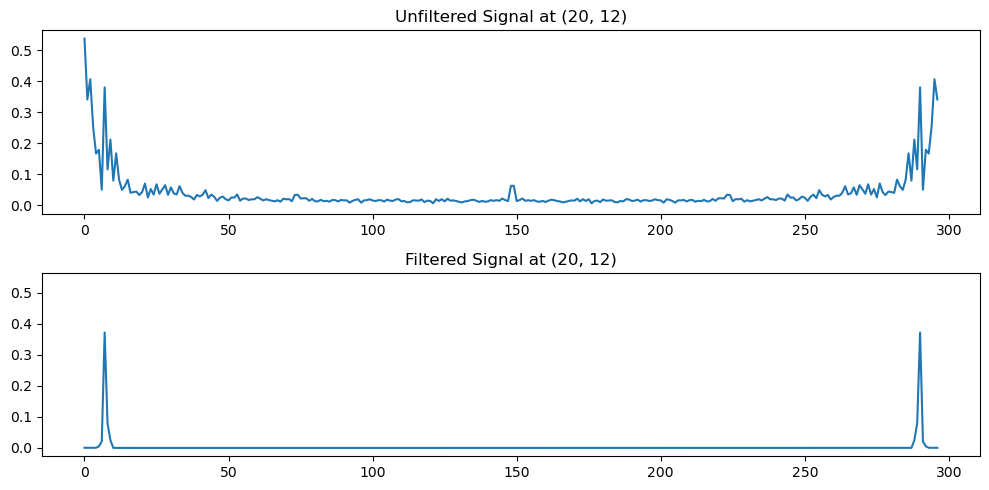

In [21]:
_, ax = plt.subplots(2, 1, figsize=(10, 5), sharey=True)

ax[0].plot(np.abs(pyr_stack_fft[2:-2, 0, 20, 12]))
ax[0].set_title("Unfiltered Signal at (20, 12)")

ax[1].plot(np.abs(_filtered_pyramid[2:-2, 0, 20, 12]))
ax[1].set_title("Filtered Signal at (20, 12)");

plt.tight_layout();

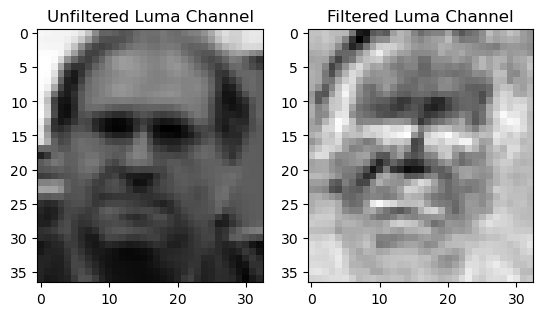

In [22]:
_, ax = plt.subplots(1, 2)
ax[0].imshow(pyramid_stack[10, 0, :, :], cmap='gray')
ax[0].set_title("Unfiltered Luma Channel")
ax[1].imshow(filtered_pyramid[10, 0, :, :], cmap='gray')
ax[1].set_title("Filtered Luma Channel");

Display filtered results at single pixel

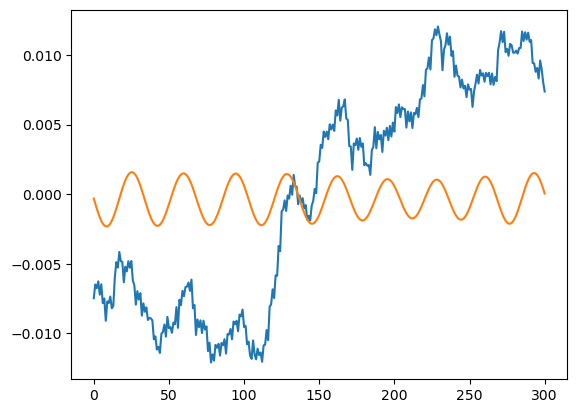

In [23]:
plt.plot(pyramid_stack[:, 0, 12, 20] - pyramid_stack[:, 0, 12, 20].mean())
plt.plot(filtered_pyramid[:, 0, 12, 20]);

## We can also apply IIR Filtering

In [24]:
b_lo, a_lo = signal.butter(N=1, Wn=f_lo/fs, btype='lowpass', output='ba')
b_hi, a_hi = signal.butter(N=1, Wn=f_hi/fs, btype='lowpass', output='ba')

In [25]:
_, pyr_c, pyr_h, pyr_w = pyramid_stack.shape

In [26]:
a_lo_arr = np.tile(a_lo, reps=(pyr_c, pyr_h, pyr_w, 1))
b_lo_arr = np.tile(b_lo, reps=(pyr_c, pyr_h, pyr_w, 1))

a_hi_arr = np.tile(a_hi, reps=(pyr_c, pyr_h, pyr_w, 1))
b_hi_arr = np.tile(b_hi, reps=(pyr_c, pyr_h, pyr_w, 1))

In [27]:
a_lo_arr.shape

(3, 37, 33, 2)

### Perform IIR Filtering

In [28]:
y_lo_arr = np.zeros_like(pyramid_stack)
y_hi_arr = np.zeros_like(pyramid_stack)

y_lo_arr[0, ...] = pyramid_stack[0, ...]
y_hi_arr[0, ...] = pyramid_stack[0, ...]

filtered = np.zeros_like(pyramid_stack)
filtered[0, ...] = 0 # pyramid_stack[0, ...]


for i in range(1, NUM_FRAMES):
    # Implement IIR Difference Equation
    # a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M]
    #                   - a[1]*y[n-1] - ... - a[N]*y[n-N]


    y_lo_arr[i, ...] = (b_lo_arr[..., 0]*pyramid_stack[i, ...]
                        + b_lo_arr[..., 1]*pyramid_stack[i - 1, ...]
                        - a_lo_arr[..., 1]*y_lo_arr[i - 1, ...]) / a_lo_arr[..., 0]
    
    y_hi_arr[i, ...] = (b_hi_arr[..., 0]*pyramid_stack[i, ...]
                        + b_hi_arr[..., 1]*pyramid_stack[i - 1, ...]
                        - a_hi_arr[..., 1]*y_hi_arr[i - 1, ...]) / a_hi_arr[..., 0]
    
    
    filtered[i, ...] = y_hi_arr[i, ...] - y_lo_arr[i, ...]

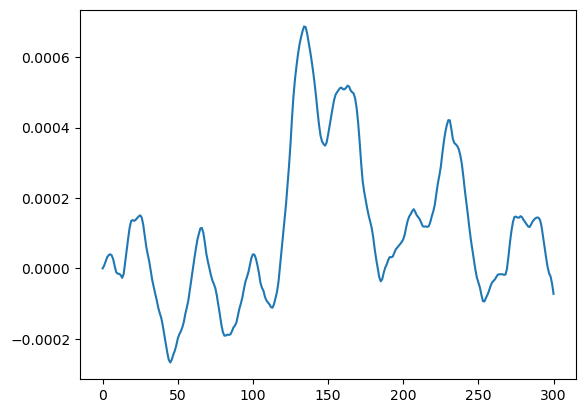

In [29]:
plt.plot(filtered[:, 0, 12, 20])

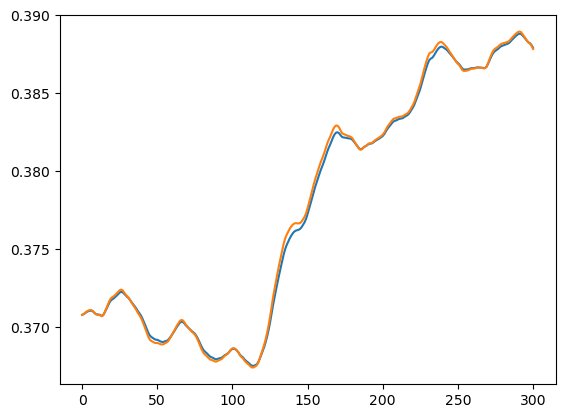

In [30]:
plt.plot(y_lo_arr[:, 0, 12, 20])
plt.plot(y_hi_arr[:, 0, 12, 20]);

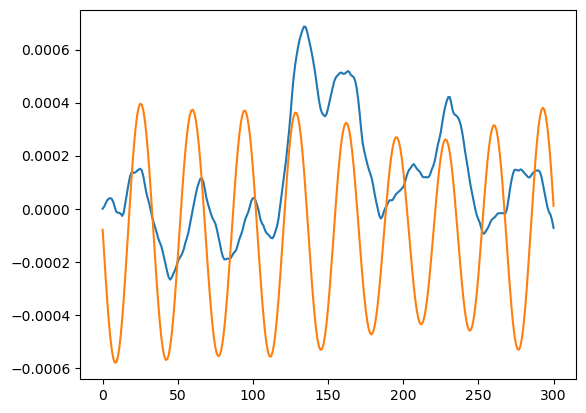

In [31]:
plt.plot(filtered[:, 0, 12, 20]);
plt.plot(filtered_pyramid[:, 0, 12, 20]/4);

### Decide whether to use IIR Filtering or not

In [32]:
filtered_pyramid = filtered

## Apply Magnification and Reconstruct Video

In [33]:
magnified_pyramid = filtered_pyramid * ALPHA

In [34]:
magnified = []
magnified_only = []

for i in range(NUM_FRAMES):
    y_chan = frames[i][:, :, 0]
    i_chan = frames[i][:, :, 1] 
    q_chan = frames[i][:, :, 2] 
    
    fy_chan = cv2.resize(magnified_pyramid[i, 0, :, :], (cols, rows))
    fi_chan = cv2.resize(magnified_pyramid[i, 1, :, :], (cols, rows))
    fq_chan = cv2.resize(magnified_pyramid[i, 2, :, :], (cols, rows))

    # apply magnification
    mag = np.dstack((
        y_chan + fy_chan,
        i_chan + fi_chan,
        q_chan + fq_chan,
    ))
    
    # normalize and convert to RGB
    mag = inv_colorspace(mag)

    # store magnified frames
    magnified.append(mag)

    # store magified only for reference
    magnified_only.append(np.dstack((fy_chan, fi_chan, fq_chan)))

Check detected heart rates

In [35]:
og_reds = []
og_blues = []
og_greens = []

reds = []
blues = []
greens = []
for i in range(NUM_FRAMES):
    # convert YIQ to RGB
    frame = inv_colorspace(frames[i])
    og_reds.append(frame[0, :, :].sum())
    og_blues.append(frame[1, :, :].sum())
    og_greens.append(frame[2, :, :].sum())

    reds.append(magnified[i][0, :, :].sum())
    blues.append(magnified[i][1, :, :].sum())
    greens.append(magnified[i][2, :, :].sum())

In [36]:
times = np.arange(0, NUM_FRAMES)/fs

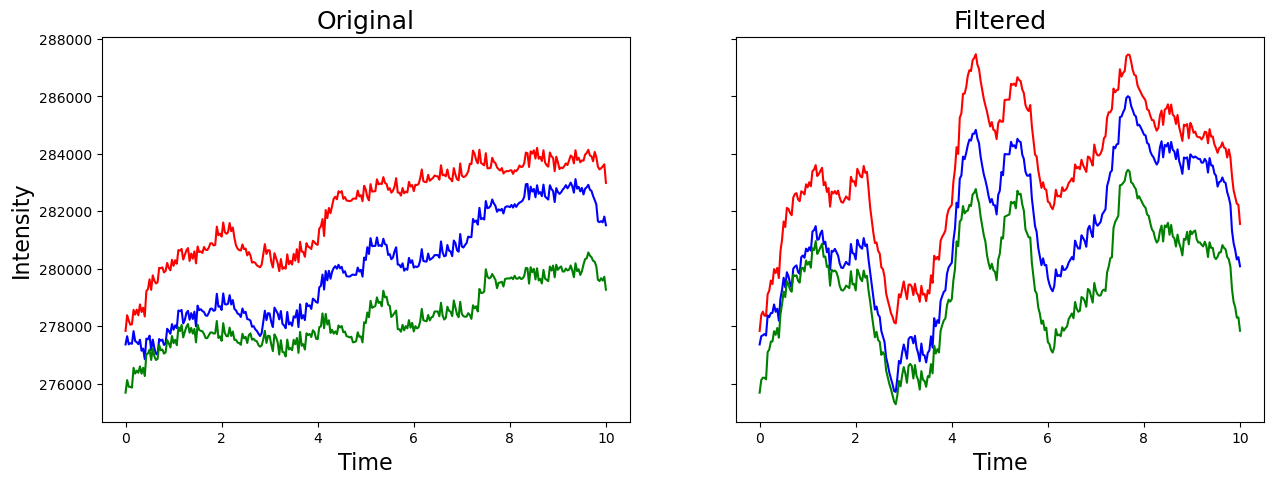

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0].plot(times, og_reds, color='red')
ax[0].plot(times, og_blues, color='blue')
ax[0].plot(times, og_greens, color='green')
ax[0].set_title("Original", size=18)
ax[0].set_xlabel("Time", size=16)
ax[0].set_ylabel("Intensity", size=16)

ax[1].plot(times, reds, color='red')
ax[1].plot(times, blues, color='blue')
ax[1].plot(times, greens, color='green')
ax[1].set_title("Filtered", size=18)
ax[1].set_xlabel("Time", size=16);

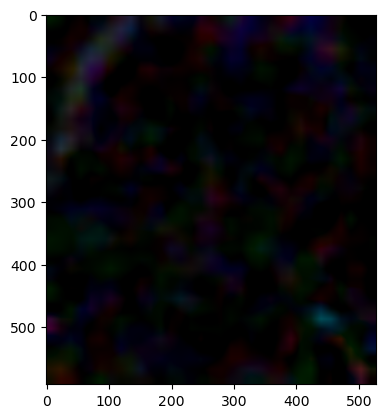

In [38]:
plt.imshow(yiq2rgb(magnified_only[10])*10)

In [39]:
freqs = np.fft.rfftfreq(NUM_FRAMES) * fs
rates = np.abs(np.fft.rfft(reds))/NUM_FRAMES

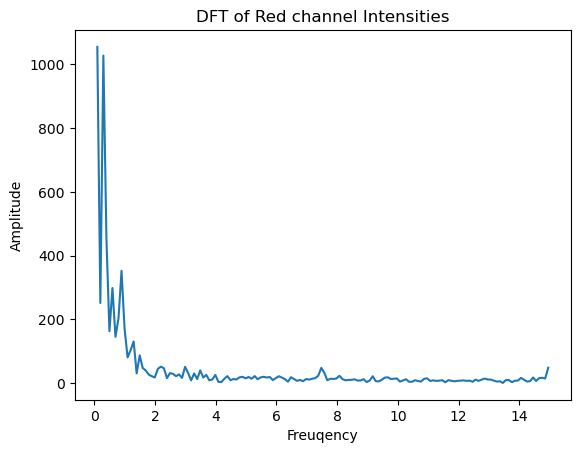

In [40]:
plt.plot(freqs[1:], rates[1:]);
plt.title("DFT of Red channel Intensities")
plt.xlabel("Freuqency")
plt.ylabel("Amplitude");

### find peak

In [41]:
idx = (freqs >= (f_lo - f_lo*0.2)) & (freqs <= (f_hi + f_hi*0.2))

In [42]:
rates[idx]

array([144.98059529, 203.04156999, 352.38364251, 171.11579593,
        80.39444186, 103.00802473])

In [43]:
peak_idx, _ = signal.find_peaks(rates[idx], height=10)

In [44]:
freqs[idx][peak_idx], rates[idx][peak_idx]

(array([0.89700997]), array([352.38364251]))

## Make a video

In [45]:
stacked_frames = []
middle = np.zeros((rows, 3, 3)).astype(np.uint8)

for vid_idx in range(NUM_FRAMES):
    og_frame = cv2.normalize(yiq2rgb(frames[vid_idx]), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC3)
    frame = np.hstack((cv2.cvtColor(og_frame, cv2.COLOR_RGB2BGR), 
                       middle, 
                       cv2.cvtColor(magnified[vid_idx], cv2.COLOR_RGB2BGR)))
    stacked_frames.append(frame)

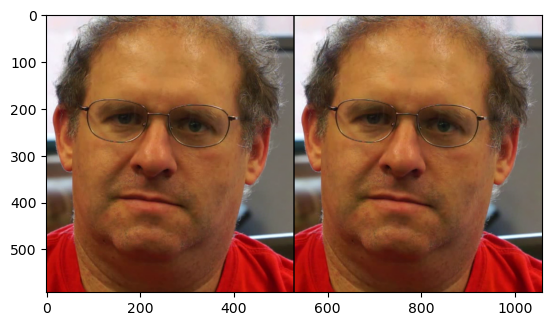

In [46]:
plt.imshow(cv2.cvtColor(stacked_frames[10], cv2.COLOR_BGR2RGB));

In [47]:
# get width and height for video frames
_h, _w, _ = stacked_frames[-1].shape

# save to mp4
out = cv2.VideoWriter(f"stacked_IIR_{int(ALPHA)}x.mp4",
                      cv2.VideoWriter_fourcc(*'MP4V'), 
                      int(fs), 
                      (_w, _h))
 
for frame in stacked_frames:
    out.write(frame)

out.release()
del out

Create a video of the magnified only frames

In [165]:
# get width and height for video frames
_h, _w, _ = magnified_only[-1].shape

# save to mp4
out = cv2.VideoWriter(f"stacked_{int(ALPHA)}x_AMP.mp4",
                      cv2.VideoWriter_fourcc(*'MP4V'), 
                      int(fs), 
                      (_w, _h))

sums = []
for frame in magnified_only:
    sums.append(frame.sum(axis=1).sum(axis=0))
    
    frame = cv2.cvtColor(
        cv2.normalize(frame*20, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1),
        cv2.COLOR_RGB2BGR)
    out.write(frame)

    

out.release()
del out

Create GIF

In [204]:
h, w, _ = stacked_frames[0].shape

In [205]:
h2 = np.round(h/2.5).astype(int)
w2 = np.round(w/2.5).astype(int)

In [206]:
from PIL import Image 


# accumulate PIL image objects
pil_images = []
for img in stacked_frames:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize=(w2, h2))
    pil_images.append(Image.fromarray(img))

# create GIF
pil_images[0].save(f"stacked_{int(ALPHA)}x.gif", 
                    format="GIF", 
                    append_images=pil_images, 
                    save_all=True, 
                    duration=50, # duration that each frame is displayed
                    loop=0)

## Visualize Amplification

In [171]:
stacked = np.array([cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in stacked_frames])

In [172]:
frame.shape

(592, 528, 3)

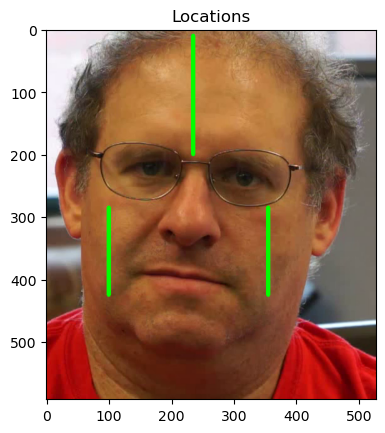

In [173]:
frame = stacked[0, :, :, :].copy()[:, :og_w, :]

forehead_idx = 235
lcheek_idx = 100
rcheek_idx = 355

cv2.line(frame, (forehead_idx, 10), (forehead_idx, 200), (0,255,0), 5)
cv2.line(frame, (lcheek_idx, 285), (lcheek_idx, 425), (0,255,0), 5)
cv2.line(frame, (rcheek_idx, 285), (rcheek_idx, 425), (0,255,0), 5)

plt.imshow(frame);
plt.title("Locations");

In [174]:
idx1 = 220 
idx2 = idx1 + og_w + 3

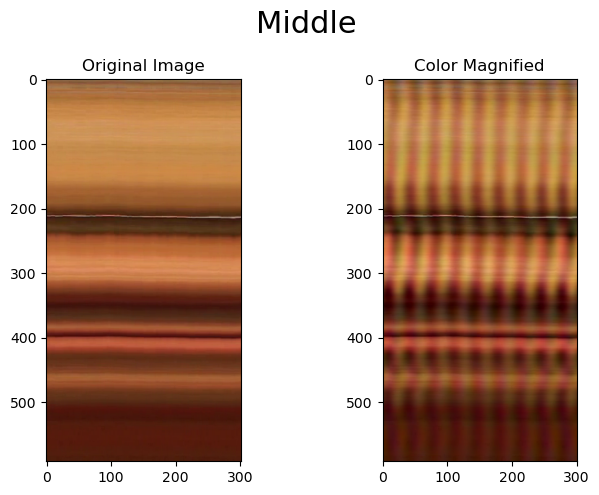

In [175]:
fig, ax = plt.subplots(1, 2, figsize=(7,5))
fig.suptitle("Middle", size=22)
ax[0].imshow(stacked[:, :, idx1, :].transpose(1, 0, 2))
ax[0].set_title("Original Image")
ax[1].imshow(stacked[:, :, idx2, :].transpose(1, 0, 2))
ax[1].set_title("Color Magnified");

plt.tight_layout();

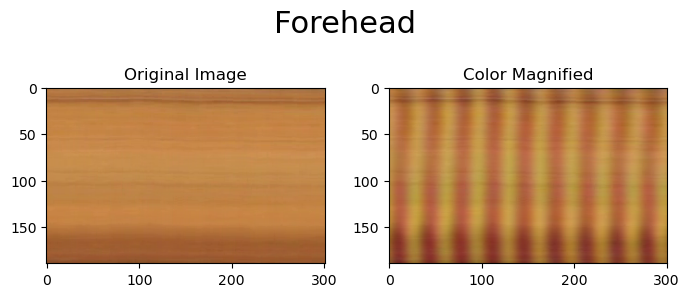

In [176]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))
fig.suptitle("Forehead", size=22)
ax[0].imshow(stacked[:, 10:200, forehead_idx, :].transpose(1, 0, 2))
ax[0].set_title("Original Image")
ax[1].imshow(stacked[:, 10:200, forehead_idx + og_w + 3, :].transpose(1, 0, 2))
ax[1].set_title("Color Magnified");

plt.tight_layout();

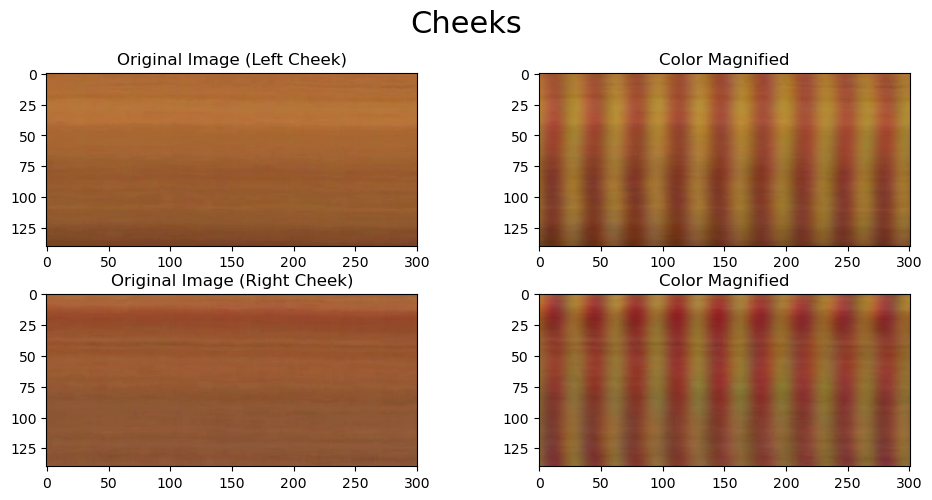

In [177]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
fig.suptitle("Cheeks", size=22)
ax[0, 0].imshow(stacked[:, 285:425, lcheek_idx, :].transpose(1, 0, 2))
ax[0, 0].set_title("Original Image (Left Cheek)")
ax[0, 1].imshow(stacked[:, 285:425, lcheek_idx + og_w + 3, :].transpose(1, 0, 2))
ax[0, 1].set_title("Color Magnified");
ax[1, 0].imshow(stacked[:, 285:425, rcheek_idx, :].transpose(1, 0, 2))
ax[1, 0].set_title("Original Image (Right Cheek)")
ax[1, 1].imshow(stacked[:, 285:425, rcheek_idx + og_w + 3, :].transpose(1, 0, 2))
ax[1, 1].set_title("Color Magnified");

plt.tight_layout();

## Let's make a real time pipeline!

In [235]:
def gaussian_level_gray(image, level):
    """ Obtains single band of a Gaussian Pyramid Decomposition
        Inputs: 
            image - single channel input image
            num_levels - number of pyramid levels
        Outputs:
            level - Pyramid Decomposition level
        """ 
    rows, cols = image.shape

    for i in range(0, level):
        
        image = cv2.pyrDown(image, dstsize=(cols//2, rows//2))
        rows, cols = image.shape

        if i == (level - 1):
            break

    return image

In [427]:
# Assume pyramid size is already known
a_lo_arr = np.tile(a_lo, reps=(pyr_h, pyr_w, 1))
b_lo_arr = np.tile(b_lo, reps=(pyr_h, pyr_w, 1))

a_hi_arr = np.tile(a_hi, reps=(pyr_h, pyr_w, 1))
b_hi_arr = np.tile(b_hi, reps=(pyr_h, pyr_w, 1))


# store data
# update this so that we only use a buffer of ~100 frames, maybe 200
y_lo_arr = []
y_hi_arr = []
pyr_levels = []
filtered_levels = []
magnified_frames = []

# assume that we are streaming in the frames!
for i, frame in enumerate(frames):

    # Get Gaussian Level on Lumma Channel
    pyr_levels.append(gaussian_level_gray(frame[:, :, 0], LEVEL))

    # filter
    if i > 0:
        y_lo = (b_lo_arr[..., 0]*pyr_levels[i]
                    + b_lo_arr[..., 1]*pyr_levels[i - 1]
                    - a_lo_arr[..., 1]*y_lo_arr[i - 1]) / a_lo_arr[..., 0]
    
        y_hi = (b_hi_arr[..., 0]*pyr_levels[i]
                    + b_hi_arr[..., 1]*pyr_levels[i - 1]
                    - a_hi_arr[..., 1]*y_hi_arr[i - 1]) / a_hi_arr[..., 0]
        
        
        filtered = y_hi - y_lo

        y_lo_arr.append(y_lo)
        y_hi_arr.append(y_hi)
        filtered_levels.append(filtered)

    else:
        y_lo_arr.append(pyr_levels[-1])
        y_hi_arr.append(pyr_levels[-1])
        filtered_levels.append(np.zeros_like(pyr_levels[-1]))
        magnified_frames.append(inv_colorspace(frame))
    



In [428]:
len(filtered_levels)

301

In [429]:
np.dstack(filtered_levels).T.shape

(301, 33, 37)

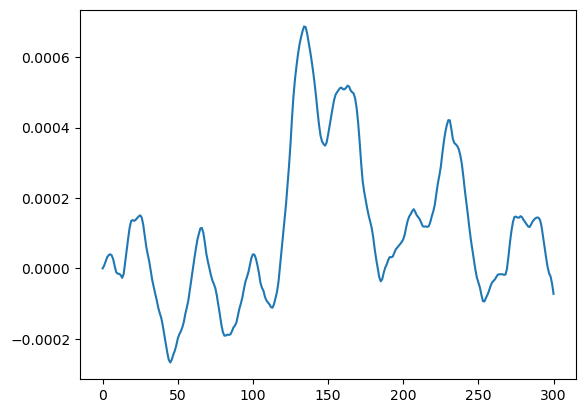

In [430]:
plt.plot(np.dstack(filtered_levels).T[:, 20, 12])

In [431]:
np.fft.rfftfreq(NUM_FRAMES).shape

(151,)

In [432]:
np.dstack(filtered_levels).T.shape

(301, 33, 37)

In [433]:
np.abs(np.fft.rfft(np.dstack(filtered_levels).sum(axis=1).sum(axis=1))).shape

(19,)

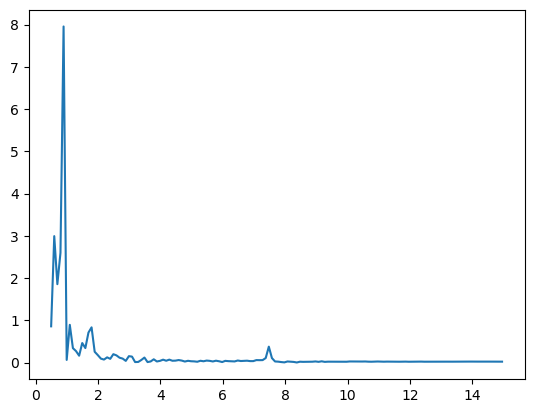

In [434]:
plt.plot(np.fft.rfftfreq(NUM_FRAMES)[5:]*fs, 
         np.abs(np.fft.rfft(np.dstack(filtered_levels).T.sum(axis=1).sum(axis=1)))[5:]);

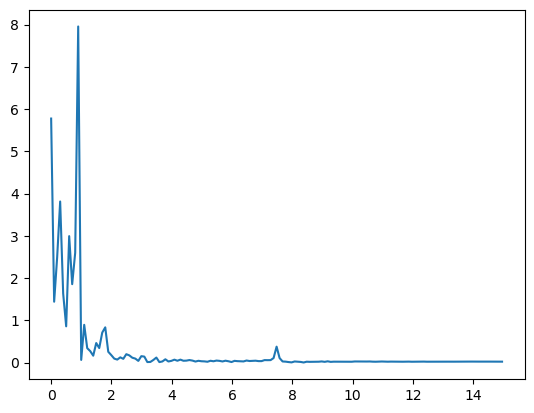

In [435]:
plt.plot(np.fft.rfftfreq(NUM_FRAMES)*fs, 
         np.abs(np.fft.rfft(np.dstack(filtered_levels).T.sum(axis=1).sum(axis=1))));

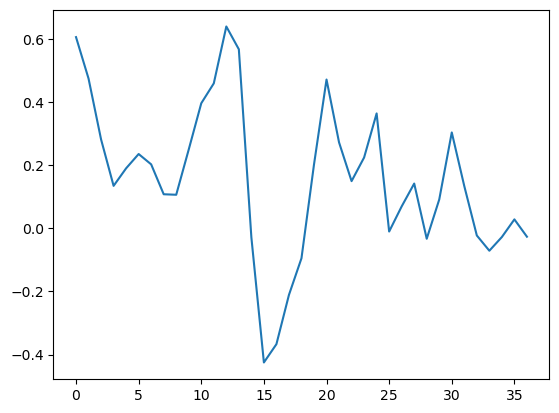

In [436]:
plt.plot(np.dstack(filtered_levels).sum(axis=1).sum(axis=1))

In [437]:
tmp = np.dstack(filtered_levels[:]).T.sum(axis=1).sum(axis=1)

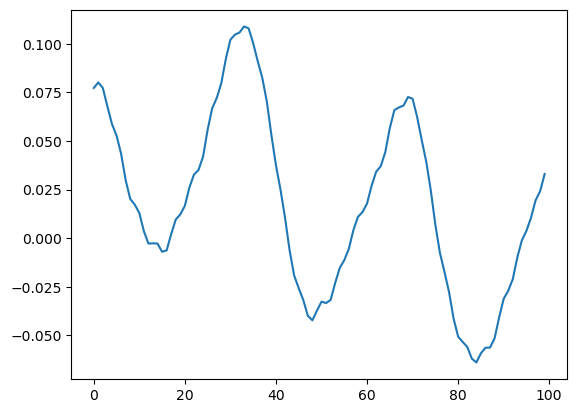

In [440]:
plt.plot(tmp[-100:])

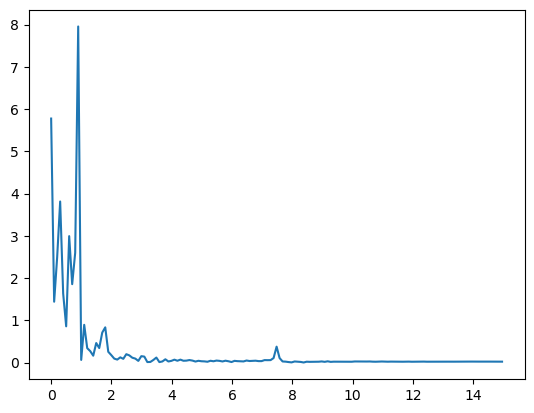

In [439]:
plt.plot(np.fft.rfftfreq(len(tmp))*fs, np.abs(np.fft.rfft(tmp)))

In [247]:
y_lo[i - 1]

IndexError: index 37 is out of bounds for axis 0 with size 37

In [233]:
y_chan = frames[i][:, :, 0]
i_chan = frames[i][:, :, 1] 
q_chan = frames[i][:, :, 2] 

fy_chan = cv2.resize(magnified_pyramid[i, 0, :, :], (cols, rows))
fi_chan = cv2.resize(magnified_pyramid[i, 1, :, :], (cols, rows))
fq_chan = cv2.resize(magnified_pyramid[i, 2, :, :], (cols, rows))

# apply magnification
mag = np.dstack((
    y_chan + fy_chan,
    i_chan + fi_chan,
    q_chan + fq_chan,
))

# normalize and convert to RGB
mag = inv_colorspace(mag)

array([], shape=(3, 0, 33), dtype=float64)

In [346]:
y_lo_arr[0].shape

(37, 33)

(37, 33)

In [473]:
# set buffer size
buffer_sz = int(fs*6) # 150

# get available frequencies
freqs = np.fft.rfftfreq(buffer_sz)*fs
heart_rates = []


## process initial frame
# Get Gaussian Level on Lumma Channel
pyr_level = gaussian_level_gray(frames[0][:, :, 0], LEVEL)

# get pyramid dimensions
pyr_h, pyr_w = pyr_level.shape

# obtain array form of filter parameters
a_lo_arr = np.tile(a_lo, reps=(pyr_h, pyr_w, 1))
b_lo_arr = np.tile(b_lo, reps=(pyr_h, pyr_w, 1))

a_hi_arr = np.tile(a_hi, reps=(pyr_h, pyr_w, 1))
b_hi_arr = np.tile(b_hi, reps=(pyr_h, pyr_w, 1))


# store data in data arrays
y_lo_arr = np.zeros((buffer_sz, pyr_h, pyr_w))
y_hi_arr = np.zeros((buffer_sz, pyr_h, pyr_w))
pyr_levels = np.zeros((buffer_sz, pyr_h, pyr_w))
filtered_levels = np.zeros((buffer_sz, pyr_h, pyr_w))
magnified_frames = []

# initialize data array
# pyr_levels[0, ...] = pyr_level
# y_lo_arr[0, ...] = pyr_levels[0, ...]
# y_hi_arr[0, ...] = pyr_levels[0, ...]
# filtered_levels[0, ...] = np.zeros((pyr_h, pyr_w))

pyr_levels[-2, ...] = pyr_level
y_lo_prev = y_lo = pyr_level
y_hi_prev = y_hi = pyr_level
filtered_levels[-2, ...] = np.zeros((pyr_h, pyr_w))

# assume that we are streaming in the frames!
for i, frame in enumerate(frames, 1):

    # get current index
    n = i % buffer_sz

    # # Get Gaussian Level on Lumma Channel
    # pyr_levels[n, ...] = gaussian_level_gray(frame[:, :, 0], LEVEL)

    # # filter
    # y_lo = (b_lo_arr[..., 0]*pyr_levels[n, ...]
    #             + b_lo_arr[..., 1]*pyr_levels[n - 1, ...]
    #             - a_lo_arr[..., 1]*y_lo_arr[n - 1, ...]) / a_lo_arr[..., 0]

    # y_hi = (b_hi_arr[..., 0]*pyr_levels[n, ...]
    #             + b_hi_arr[..., 1]*pyr_levels[n - 1, ...]
    #             - a_hi_arr[..., 1]*y_hi_arr[n - 1, ...]) / a_hi_arr[..., 0]
    
    
    # filtered = y_hi - y_lo

    # y_lo_arr[n, ...] = y_lo
    # y_hi_arr[n, ...] = y_hi
    # filtered_levels[n, ...] = filtered

    # need to roll these

    # Get Gaussian Level on Lumma Channel
    pyr_levels[-1, ...] = gaussian_level_gray(frame[:, :, 0], LEVEL)

    # filter
    y_lo = (b_lo_arr[..., 0]*pyr_levels[-1, ...]
                + b_lo_arr[..., 1]*pyr_levels[-2, ...]
                - a_lo_arr[..., 1]*y_lo_prev) / a_lo_arr[..., 0]

    y_hi = (b_hi_arr[..., 0]*pyr_levels[-1, ...]
                + b_hi_arr[..., 1]*pyr_levels[-2, ...]
                - a_hi_arr[..., 1]*y_hi_prev) / a_hi_arr[..., 0]
    

    # get Filtered Pyramid level
    filtered_levels[-1, ...] = y_hi - y_lo

    # Estimate frequency spectrum
    fmag = np.abs(np.fft.rfft(filtered_levels.sum(axis=1).sum(axis=1)))
    peak_idx, _ = signal.find_peaks(fmag, 
                                    height=0.4*fmag.max(),
                                    distance=5)
    if len(peak_idx) > 0:
        heart_rates.append(freqs[peak_idx][0])
    else:
        heart_rates.append(0)

    # store LPF signals for next iteration
    y_lo_prev = y_lo
    y_hi_prev = y_hi

    # roll arrays for next iteration
    pyr_levels = np.roll(pyr_levels, shift=-1, axis=0)
    filtered_levels = np.roll(filtered_levels, shift=-1, axis=0)

    # TEMP
        
    

In [469]:
30*6

180

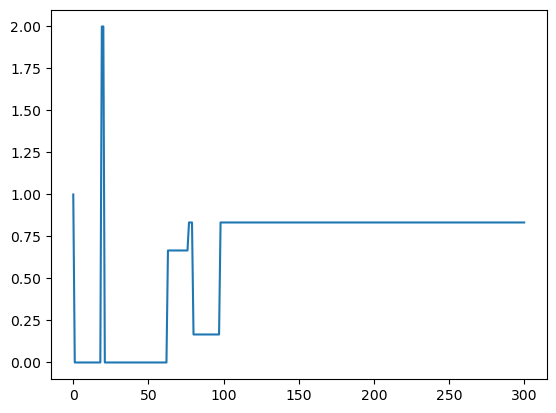

In [472]:
plt.plot(heart_rates)

In [464]:
len(peak_idx) > 0

False

In [450]:
freqs

array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ,
        3.3,  3.6,  3.9,  4.2,  4.5,  4.8,  5.1,  5.4,  5.7,  6. ,  6.3,
        6.6,  6.9,  7.2,  7.5,  7.8,  8.1,  8.4,  8.7,  9. ,  9.3,  9.6,
        9.9, 10.2, 10.5, 10.8, 11.1, 11.4, 11.7, 12. , 12.3, 12.6, 12.9,
       13.2, 13.5, 13.8, 14.1, 14.4, 14.7, 15. ])

In [442]:
# unroll after final iteration
pyr_levels = np.roll(pyr_levels, shift=-1, axis=0)
filtered_levels = np.roll(filtered_levels, shift=1, axis=0)

In [443]:
tmp = np.roll(pyr_levels, shift=1, axis=0)

In [444]:
tmp[0, ...] - pyr_levels[-1, ...]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

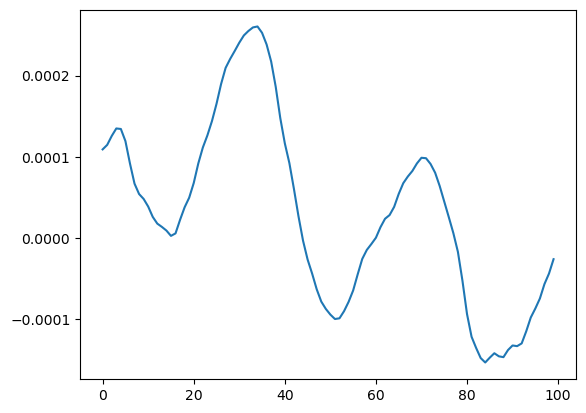

In [445]:
plt.plot(filtered_levels[:, 10, 10])

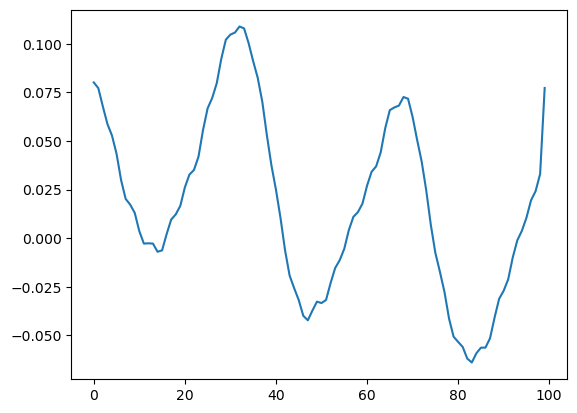

In [451]:
plt.plot(filtered_levels.sum(axis=1).sum(axis=1))

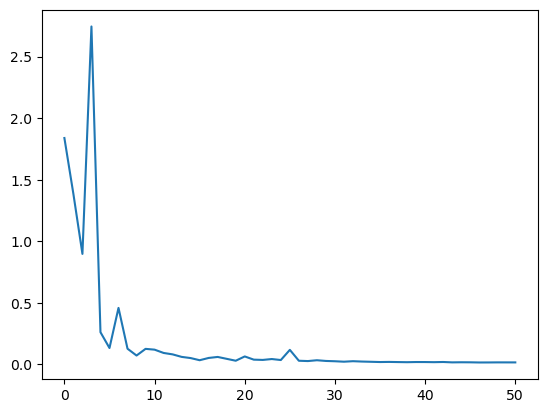

In [452]:
plt.plot(fmag)

In [381]:
for i in range(1, 201):
    print(i, i % 100)
    if i % 100 == 0:
        print(i)


1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
81 81
82 82
83 83
84 84
85 85
86 86
87 87
88 88
89 89
90 90
91 91
92 92
93 93
94 94
95 95
96 96
97 97
98 98
99 99
100 0
100
101 1
102 2
103 3
104 4
105 5
106 6
107 7
108 8
109 9
110 10
111 11
112 12
113 13
114 14
115 15
116 16
117 17
118 18
119 19
120 20
121 21
122 22
123 23
124 24
125 25
126 26
127 27
128 28
129 29
130 30
131 31
132 32
133 33
134 34
135 35
136 36
137 37
138 38
139 39
140 40
141 41
142 42
143 43
144 44
145 45
146 46
147 47
148 48
149 49
150 50
151 51
152 52
153 53
154 54
155 55
156 56
157 57
158 58
159 59
160 60
161

In [395]:
arr = np.arange(0, 10)

In [396]:
np.roll(arr, shift=-1)

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

In [404]:
arr = np.zeros(10,)
arr[-2] = 1
arr[-1] = 1

arr

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])

In [405]:
np.roll(arr, shift=-1)

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 0.])

In [365]:
arr = np.zeros(10)
data = np.random.randint(0, 25, 15)
for i in range(len(data)):
    arr[-1] = data[i]

    # shift data for next iteration
    arr = np.roll(arr, shift=-1)

In [366]:
arr

array([ 9., 23., 15., 16., 18.,  7., 24.,  7.,  0.,  5.])

In [368]:
data

array([ 3, 15, 16,  7,  7,  5,  9, 23, 15, 16, 18,  7, 24,  7,  0])